# PREPARE ENVIRONMENT

In [9]:
#Import necessary packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [10]:
#print version of sklearn package we are using
import sklearn
print(sklearn.__version__)

1.2.2


# DATA PREPROCESSING

Here we will load and process the data such that we can use it to train our model. The output will be a labeled data set consisting of train and test samples.

In [11]:
#Load Calliope generated data
calliope_data = pd.read_excel('/kaggle/input/data-gas-month-sin-cos/gasprice_2_feat_monthly_2019_data.xlsx')

print(calliope_data.shape)

#Extract features and output (cost)
X = calliope_data.drop(columns = ['Month', "Cost", "Scenario", "Month_encoded"], axis=1)
y = calliope_data['Cost']

print(X.head())
print(y.head())

print(f"Mean of Costs is {np.mean(y)} and Std of Costs is {np.std(y)}")

#use a random plit to create train and test sets
X_train,X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 42)


(360, 7)
   Month_sin     Month_cos  Gas Price
0   0.500000  8.660254e-01       0.01
1   0.866025  5.000000e-01       0.01
2   1.000000  6.125742e-17       0.01
3   0.866025 -5.000000e-01       0.01
4   0.500000 -8.660254e-01       0.01
0    73371.965589
1    60291.293182
2    41651.632667
3    34311.615148
4    46031.414752
Name: Cost, dtype: float64
Mean of Costs is 648313.7862656774 and Std of Costs is 412106.3235621424


In [12]:
# Scale features
calliope_scaler = StandardScaler()

X_train = calliope_scaler.fit_transform(X_train)

X_test = calliope_scaler.transform(X_test)


# TRAIN MODELS

In this section, will train three different ML models: Linear Regression, Decision Tree and Random Forest. We will start by applying grid search using a train data set. After this configuration, we will evaluate the models using unseen test data. 

In [ ]:
#Set up parameter grid for each ML model
#We do not perform grid search on the Linear Regression Model,
#since there are no hyperparameters to tune

param_grid_dt = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10,20,50],
}

param_grid_rf = {
    'n_estimators': [50, 100, 200,500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10, 20, 50]
}


In [8]:
#Set up GridSearchCV for the models
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_absolute_error', cv=5)

dt = DecisionTreeRegressor(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt,scoring='neg_mean_absolute_error', cv=5)

# Fit the models using the training data set
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_

# Print results of the hypertuning
print("Best parameters for Decision Tree:", best_params_dt)
print("Best parameters for Random Forest:", best_params_rf)



NameError: name 'param_grid_rf' is not defined

In [13]:
#Define best ML models - according to the hypertuning
#Only use if grid search has been performed
# rf_model = grid_search_rf.best_estimator_
# dt_model = grid_search_dt.best_estimator_

#Define Linear Regression Model
lr_model = LinearRegression()

#Define DecisionTree and RandomForest Model - only use if gridsearch has not been performed
rf_model = RandomForestRegressor(random_state = 42)
dt_model = DecisionTreeRegressor(random_state=42)

# EVALUATE MODELS

We start by defining a function to evaluate the ML models. The intrinsic metric has been set to be the Mean Absolute Error.

In [14]:
def evaluate_model(ML_model):
    #Fit model
    ML_model.fit(X_train, y_train)
    
    #Predict the costs
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    
    #calculate MAE (intrinsic accuracy metric)
    train_mae = mean_absolute_error(y_train_pred, y_train)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return y_test_pred,np.mean(train_mae),np.mean(test_mae)

Now we will apply these functions on the ML models.

In [15]:
#Evaluate ML Models
lr_test_pred, lr_train_mae, lr_test_mae = evaluate_model(lr_model)
dt_test_pred, dt_train_mae, dt_test_mae = evaluate_model(dt_model)
rf_test_pred, rf_train_mae, rf_test_mae = evaluate_model(rf_model)

print("Final MAE train data LR:", lr_train_mae)
print("Final MAE test data  LR:", lr_test_mae)
print("Final MAE train data DT:", dt_train_mae)
print("Final MAE test data  DT:", dt_test_mae)
print("Final MAE train data RF:", rf_train_mae)
print("Final MAE test data  RF:", rf_test_mae)

Final MAE train data LR: 128281.3503759683
Final MAE test data  LR: 145478.99209394964
Final MAE train data DT: 0.0
Final MAE test data  DT: 59198.61081371104
Final MAE train data RF: 15074.769962948485
Final MAE test data  RF: 47319.574912923905


# Visualizing Results Gas Price vs Cost

We will only visualise the results using the predicted costs of the Random Forest Regressor, as this model turned out to perform best (i.e., it had the lowest MAE value).

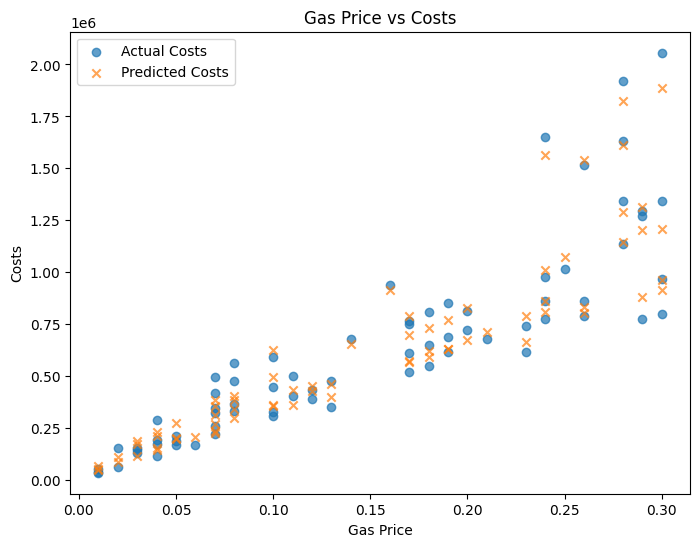

In [28]:
def plot_gas_price_vs_costs(gas_price, actual_costs, predicted_costs):
    """Plot Gas Price vs Costs (Actual and Predicted)"""
    plt.figure(figsize=(8, 6))
    plt.scatter(gas_price, actual_costs, label='Actual Costs', alpha=0.7)
    plt.scatter(gas_price, predicted_costs, label='Predicted Costs', alpha=0.7, marker='x')
    plt.title('Gas Price vs Costs')
    plt.xlabel('Gas Price')
    plt.ylabel('Costs')
    plt.legend()
    plt.savefig("plot_gas_month_pred.png", format='png', dpi=300)
    plt.show()

#scale gas prices back to actual gas prices
scaled_gas_prices = X_test[:, 2]
# Create a placeholder array with the same number of features as the original data
placeholder = np.zeros_like(X_test)
placeholder[:, 2] = scaled_gas_prices  # Put the scaled gas prices in the correct column
gas_price = calliope_scaler.inverse_transform(placeholder)[:, 2]  # Extract the original values for the gas prices

actual_costs = y_test
predicted_costs = rf_test_pred

#plot
plot_gas_price_vs_costs(gas_price, actual_costs, predicted_costs)

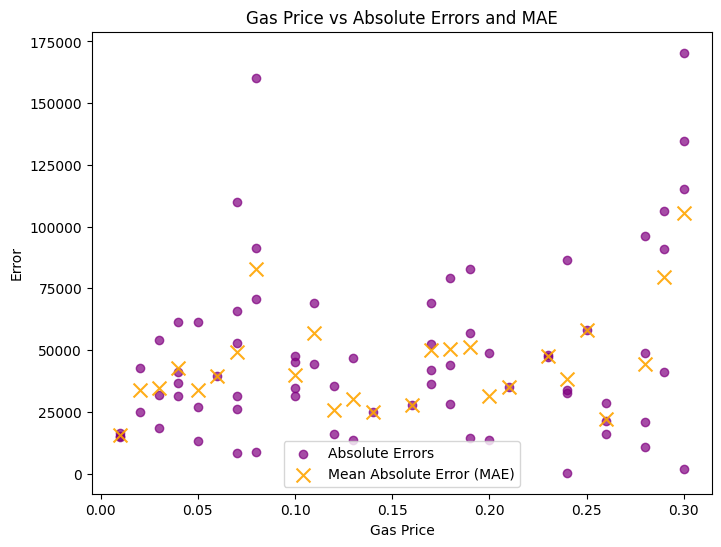

In [29]:
def plot_gas_price_vs_errors(gas_price, actual_costs, predicted_costs):
    """
    Plot Gas Price vs Absolute Errors and Mean Absolute Error (MAE).
    
    Args:
        gas_price (array-like): Array of gas prices.
        actual_costs (array-like): Array of actual costs.
        predicted_costs (array-like): Array of predicted costs.
    """
    # Calculate absolute errors
    absolute_errors = abs(predicted_costs - actual_costs)

    # Create a DataFrame for grouping by gas price
    import pandas as pd
    data = pd.DataFrame({
        'gas_price': gas_price,
        'absolute_error': absolute_errors
    })

    # Calculate MAE per gas price
    mae_per_gas_price = data.groupby('gas_price')['absolute_error'].mean().reset_index()

    # Plot absolute errors
    plt.figure(figsize=(8, 6))
    plt.scatter(gas_price, absolute_errors, label='Absolute Errors', alpha=0.7, c='purple')
    
    # Plot MAE per gas price
    plt.scatter(mae_per_gas_price['gas_price'], mae_per_gas_price['absolute_error'], 
                label='Mean Absolute Error (MAE)', alpha=0.9, c='orange', marker='x', s=100)

    # Add labels, legend, and title
    plt.title('Gas Price vs Absolute Errors and MAE')
    plt.xlabel('Gas Price')
    plt.ylabel('Error')
    plt.legend()
    plt.savefig("plot_gas_month_error.png", format='png', dpi=300)
    plt.show()


plot_gas_price_vs_errors(gas_price, actual_costs, predicted_costs)


# Visualise Result Months vs Cost

In [30]:
# Compute the month from sine and cosine values
def compute_month(sin_values, cos_values):
    angles = np.arctan2(sin_values, cos_values)  # Calculate angle in radians
    months = (np.round((angles % (2 * np.pi)) / (2 * np.pi) * 12) + 1).astype(int)  # Map angle to month (1-12)
    return months

# Calculate months
sin_values = X_test[:, 0]
cos_values = X_test[:, 1]
months = compute_month(sin_values, cos_values)

# Create a DataFrame
data = pd.DataFrame({
    'month': months,
    'sine': sin_values,
    'cosine': cos_values,
    'predicted_cost': rf_test_pred,
    'actual_cost': y_test
})

# Group data by month
grouped_data = data.groupby('month')

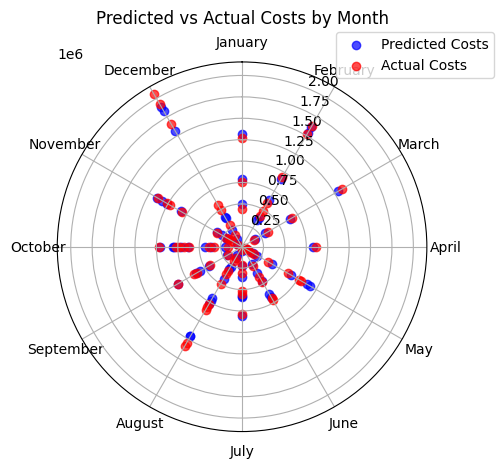

In [31]:
def plot_circular_months_costs(grouped_data):
    """
    Plots predicted and actual costs for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Scatter plot data
    predicted_angles = []
    predicted_costs = []
    actual_angles = []
    actual_costs = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Add predicted and actual costs to the respective lists
        predicted_angles.extend([angle] * len(group))
        predicted_costs.extend(group['predicted_cost'])
        actual_angles.extend([angle] * len(group))
        actual_costs.extend(group['actual_cost'])

    # Scatter plot for predicted costs
    ax.scatter(predicted_angles, predicted_costs, c='blue', label='Predicted Costs', alpha=0.7)

    # Scatter plot for actual costs
    ax.scatter(actual_angles, actual_costs, c='red', label='Actual Costs', alpha=0.7)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Predicted vs Actual Costs by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("plot_month_cost_pred.png", format='png', dpi=300)
    plt.show()

# Call the plotting function
plot_circular_months_costs(grouped_data)

In [32]:
#Now we aggregate the data to look at the avg costs per month

# Compute the month from sine and cosine values
def compute_month(sin_values, cos_values):
    angles = np.arctan2(sin_values, cos_values)  # Calculate angle in radians
    months = (np.round((angles % (2 * np.pi)) / (2 * np.pi) * 12) + 1).astype(int)  # Map angle to month (1-12)
    return months

# Create a DataFrame
sin_values = X_test[:, 0]  # Sine values
cos_values = X_test[:, 1]  # Cosine values
months = compute_month(sin_values, cos_values)

data = pd.DataFrame({
    'month': months,
    'predicted_cost': rf_test_pred,
    'actual_cost': y_test
})

# Aggregate by month
aggregated_data = data.groupby('month').agg({
    'predicted_cost': 'mean',
    'actual_cost': 'mean'
}).reset_index()

# Add radial angle for plotting
aggregated_data['angle'] = 2 * np.pi * (aggregated_data['month'] - 1) / 12


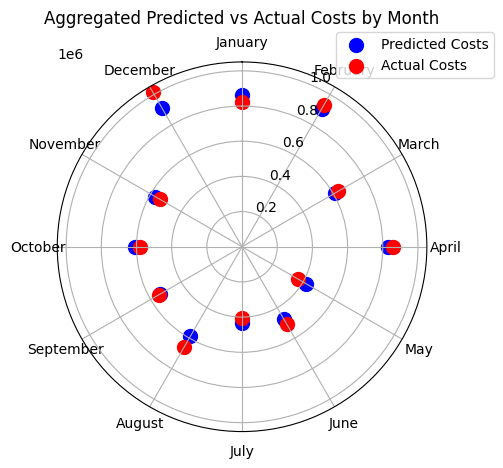

In [33]:
def plot_aggregated_circular_month_costs(aggregated_data):
    """
    Plots aggregated predicted and actual costs by month on a circular plot with month names as labels.
    
    Args:
        aggregated_data (pd.DataFrame): Aggregated data containing 'month', 'predicted_cost', 'actual_cost', and 'angle'.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Plot predicted costs
    ax.scatter(aggregated_data['angle'], aggregated_data['predicted_cost'], 
               c='blue', label='Predicted Costs', s=100)

    # Plot actual costs
    ax.scatter(aggregated_data['angle'], aggregated_data['actual_cost'], 
               c='red', label='Actual Costs', s=100)

    # Add radial grid with month names instead of numeric angles
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Aggregated Predicted vs Actual Costs by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("plot_month_cost_aggregated_pred.png", format='png', dpi=300)
    plt.show()

# Plot aggregated data with month names
plot_aggregated_circular_month_costs(aggregated_data)

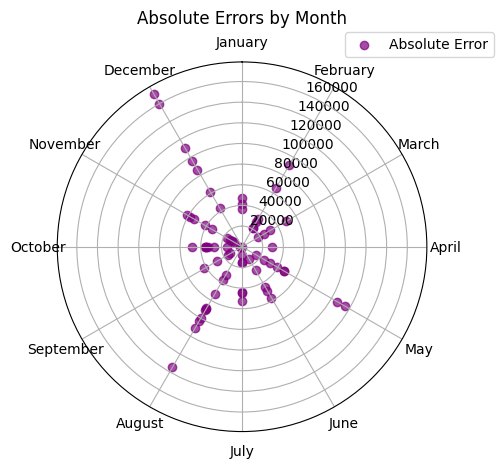

In [34]:
def plot_absolute_errors_grouped_by_month(grouped_data):
    """
    Plots the absolute errors for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Data for absolute errors
    angles = []
    absolute_errors = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Compute absolute errors
        abs_error = (group['predicted_cost'] - group['actual_cost']).abs()

        # Add to the lists for plotting
        angles.extend([angle] * len(abs_error))
        absolute_errors.extend(abs_error)

    # Scatter plot for absolute errors
    scatter = ax.scatter(angles, absolute_errors, c='purple', label='Absolute Error', alpha=0.7)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Absolute Errors by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("plot_month_errors.png", format='png', dpi=300)
    # Show the plot
    plt.show()


# Call the updated function
plot_absolute_errors_grouped_by_month(grouped_data)

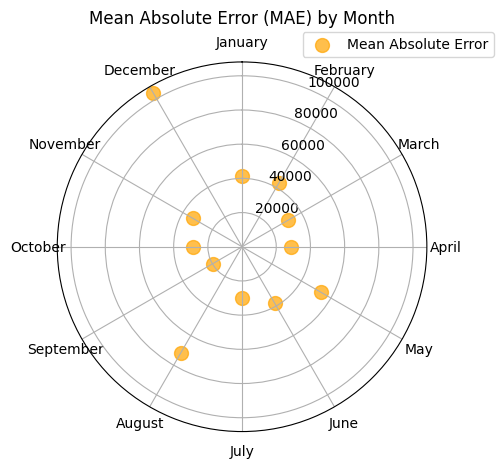

In [35]:
def plot_mean_absolute_error_grouped_by_month(grouped_data):
    """
    Plots the mean absolute error (MAE) for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Data for mean absolute errors
    angles = []
    mean_absolute_errors = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Compute the mean absolute error for the month
        mae = (group['predicted_cost'] - group['actual_cost']).abs().mean()

        # Add to the lists for plotting
        angles.append(angle)
        mean_absolute_errors.append(mae)

    # Scatter plot for mean absolute errors
    ax.scatter(angles, mean_absolute_errors, c='orange', label='Mean Absolute Error', alpha=0.7, s=100)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Mean Absolute Error (MAE) by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("plot_month_mae.png", format='png', dpi=300)
    # Show the plot
    plt.show()

# Call the function
plot_mean_absolute_error_grouped_by_month(grouped_data)

# Visualise Results Months Gas and Cost (3D)

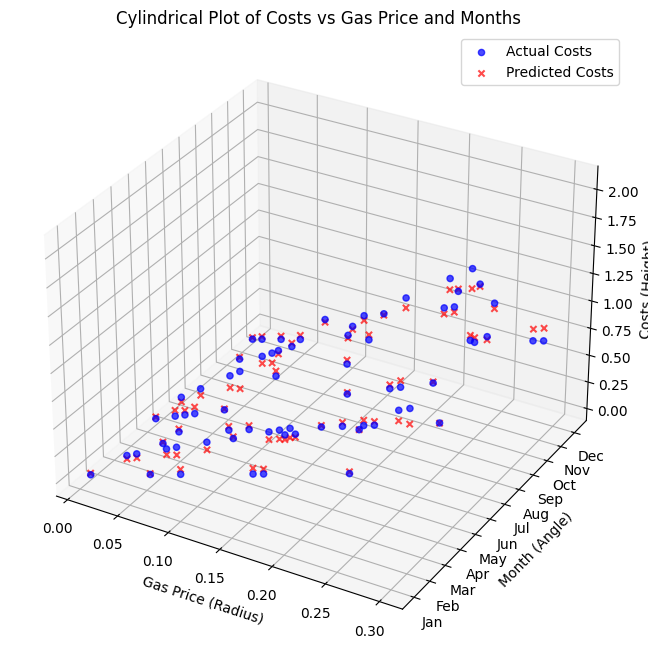

In [36]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot_cylindrical_costs(gas_price, months_sin, months_cos, actual_costs, predicted_costs):
    """
    Plot costs on a cylindrical plot where the radius corresponds to gas price,
    the angle corresponds to cyclically encoded months, and the height corresponds to costs.
    
    Args:
        gas_price (array-like): Array of gas prices (radius).
        months_sin (array-like): Sine values of cyclically encoded months.
        months_cos (array-like): Cosine values of cyclically encoded months.
        actual_costs (array-like): Actual costs (height).
        predicted_costs (array-like): Predicted costs (height).
    """
    # Compute angles from sine and cosine values
    angles = np.arctan2(months_sin, months_cos)

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot actual costs
    ax.scatter(gas_price, angles, actual_costs, c='blue', label='Actual Costs', alpha=0.7)

    # Plot predicted costs
    ax.scatter(gas_price, angles, predicted_costs, c='red', label='Predicted Costs', alpha=0.7, marker='x')

    # Add labels and title
    ax.set_title('Cylindrical Plot of Costs vs Gas Price and Months')
    ax.set_xlabel('Gas Price (Radius)')
    ax.set_ylabel('Month (Angle)')
    ax.set_zlabel('Costs (Height)')
    ax.legend()

    # Set y-axis ticks to correspond to months
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_yticks(np.linspace(-np.pi, np.pi, 12, endpoint=False))
    ax.set_yticklabels(month_labels)
    plt.savefig("kube_month_gas_cost.png", format='png', dpi=300)
    plt.show()


months_sin = X_test[:,0]
months_cos = X_test[:,1]
actual_costs = y_test
predicted_costs = rf_test_pred

# Call the function
plot_cylindrical_costs(gas_price, months_sin, months_cos, actual_costs, predicted_costs)


# 3D cylindrical plot

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


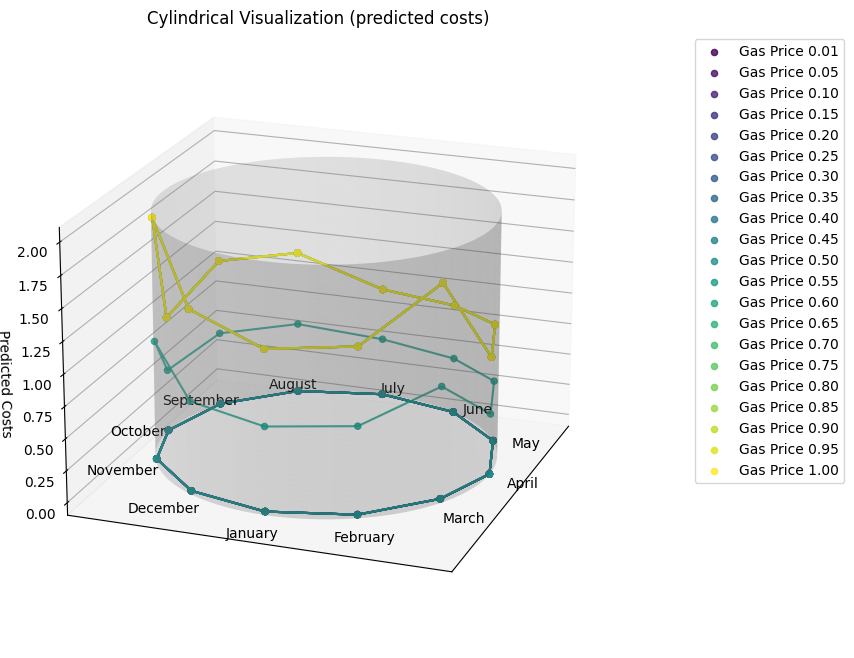

In [38]:
file_path = "/kaggle/input/surrogate-gas-price-data-zelf/surrogate_data_gas_zelfgemaakt.xlsx"
cilinder_data = pd.read_excel(file_path)
scaler_Xc = StandardScaler()
scaler_yc = StandardScaler()
Xc = cilinder_data.iloc[:,2:5].values
Xc = scaler_Xc.fit_transform(Xc)

def cilinder(model):
    # X_test3_unscaled etc. aanmaken
    Xc_unscaled = scaler_Xc.inverse_transform(Xc)
    month_cos = Xc_unscaled[:, 1]
    month_sin = Xc_unscaled[:, 0]
    gas_prices = Xc_unscaled[:, 2]
    predicted_costs = cilinder_model.predict(Xc)
    unique_gas_prices = np.unique(gas_prices)
    gas_price_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_gas_prices)))
    months = np.linspace(0, 2 * np.pi, 12, endpoint=False)
    month_labels = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    # Helperfunctie voor het plotten
    def plot_costs(ax, costs, title, color, linestyle, marker):
        for idx, gas_price in enumerate(unique_gas_prices):
            # Filter points for this gas price
            indices = np.where(gas_prices == gas_price)[0]
            x = month_cos[indices]
            y = month_sin[indices]
            z = costs[indices]
            
            # Sort the points by month to ensure continuity
            
            sorted_indices = np.argsort(np.arctan2(y, x))  # Sort by angle (month order)
            x = x[sorted_indices]
            y = y[sorted_indices]
            z = z[sorted_indices]
            x_closed = np.append(x, x[0])
            y_closed = np.append(y, y[0])
            z_closed = np.append(z, z[0])
            
            local_color = gas_price_colors[idx]
    
            # Plot the points and lines
            ax.scatter(x, y, z, color=local_color, marker=marker, 
                       label=f'Gas Price {gas_price:.2f}', alpha=0.8)
            ax.plot(x_closed, y_closed, z_closed, linestyle=linestyle, color=local_color, alpha=0.8)

        # Semi-transparent cylinder
        theta_cylinder = np.linspace(0, 2 * np.pi, 100)
        z_cylinder = np.linspace(min(costs), max(costs), 50)
        theta_cylinder, z_cylinder = np.meshgrid(theta_cylinder, z_cylinder)
        x_cylinder = np.cos(theta_cylinder)
        y_cylinder = np.sin(theta_cylinder)
        ax.plot_surface(x_cylinder, y_cylinder, z_cylinder, 
                        alpha=0.2, color='gray', edgecolor='none')

        # Add month labels to the circle
        # Add month labels to the circle
        for i, month_label in enumerate(month_labels):
            x_label = 1.2 * np.cos(months[i])  # Slightly outward for visibility
            y_label = 1.2 * np.sin(months[i])
            ax.text(x_label, y_label, 0, month_label, ha='center', va='center', fontsize=10)
        
        # Hide axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('Predicted Costs')
        ax.set_title(title)
        
        # Set viewing angle
        ax.view_init(elev=20, azim=20)
        
        # Place legend outside the plot
        ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

    # Maak de figuur en plot
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    plot_costs(ax1, predicted_costs, 
               'Cylindrical Visualization (predicted costs)',
               color='blue', linestyle='solid', marker='o')
    plt.savefig("plot_3d_cylinder_gas_month.png", format='png', dpi=300)
    plt.show()


cilinder_model = RandomForestRegressor(random_state = 42)
cilinder_model.fit(X,y)

cilinder(cilinder_model)